# No Growth Deployment Calculations
We will think of the need for reactors in terms of their power capacity. When a LWR is retired, it will be replaced by an equivalent capacity of the advanced reactor models considered in the work.

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib
from collections import defaultdict
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [2]:
sys.path.insert(0,'../../../scripts')

In [3]:
import reactor_deployment as dep
import scenario_definitions as sd

## First, pull in the LWR data

In [4]:
# read in the LWR deployment data so we can establish a baseline.
lwr_df = pd.read_csv('lwr_info.csv')

# Remove the 'Unnamed: 0' column
lwr_df = lwr_df.drop('Unnamed: 0', axis=1)

In [5]:
# create the simulation retirement year (either the actual retirement or 80
# years after the startup year)
lwr_df['retirement_year'] = lwr_df['Actual retirement (year)'].fillna(
    lwr_df['Startup date (year) b'] + 80)

In [6]:
lwr_df

,Reactor name,State,Reactor type,Reactor vendora,Core size (number of assemblies),Startup date (year) b,License expiration (year),Actual retirement (year),power_cap(MWe),retirement_year
0,Arkansas_Nuclear_One_1,AR,PWR,B&W,177,1974,2034,NaN,836.0,2054.0
1,Arkansas_Nuclear_One_2,AR,PWR,CE,177,1978,2038,NaN,988.0,2058.0
2,Beaver_Valley_1,PA,PWR,WE,157,1976,2036,NaN,908.0,2056.0
3,Beaver_Valley_2,PA,PWR,WE,157,1987,2047,NaN,905.0,2067.0
4,Big_Rock_Point,MI,BWR,GE,84,1964,NaN,1997.0,67.0,1997.0
...,...,...,...,...,...,...,...,...,...,...
118,Watts_Bar_2,TN,PWR,WE,193,2016,2055,NaN,1164.0,2096.0
119,Wolf_Creek_1,KS,PWR,WE,193,1985,2045,NaN,1200.0,2065.0
120,Yankee_Rowe,MA,PWR,WE,76,1960,NaN,1991.0,167.0,1991.0
121,Zion_1,IL,PWR,WE,193,1973,NaN,1997.0,1040.0,1997.0


In [7]:
capacity_change = {year: 0 for year in range(sd.sim_start_yr, sd.sim_end_yr)}

# calculate the decommissioned capacity for each retirement year
for year, power in zip(lwr_df['retirement_year'], lwr_df['power_cap(MWe)']):
    capacity_change[int(year)] -= power * sd.lwr_capacity_factor

# calculate the commissioned LWR capacity for each startup year
for year, power in zip(lwr_df['Startup date (year) b'], lwr_df['power_cap(MWe)']):
    capacity_change[int(year)] += power * sd.lwr_capacity_factor

/tmp/ipykernel_13964/3600157219.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


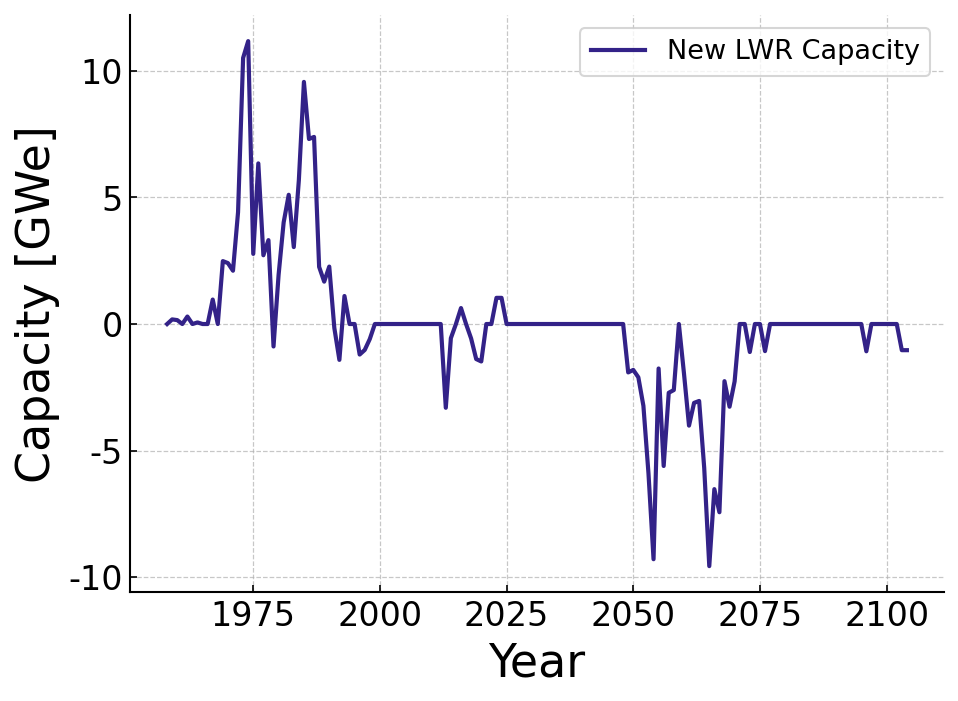

In [8]:
# Convert to a pandas DataFrame and plot.
capacity_change_df = pd.DataFrame(capacity_change.values(), index=capacity_change.keys(), columns=['new_LWR_Capacity'])
capacity_change_df.plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('New LWR Capacity')

In [9]:
# create a total lwr capacity column
capacity_change_df['Total LWR Capacity'] = capacity_change_df['new_LWR_Capacity'].cumsum()

/tmp/ipykernel_13964/722816693.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


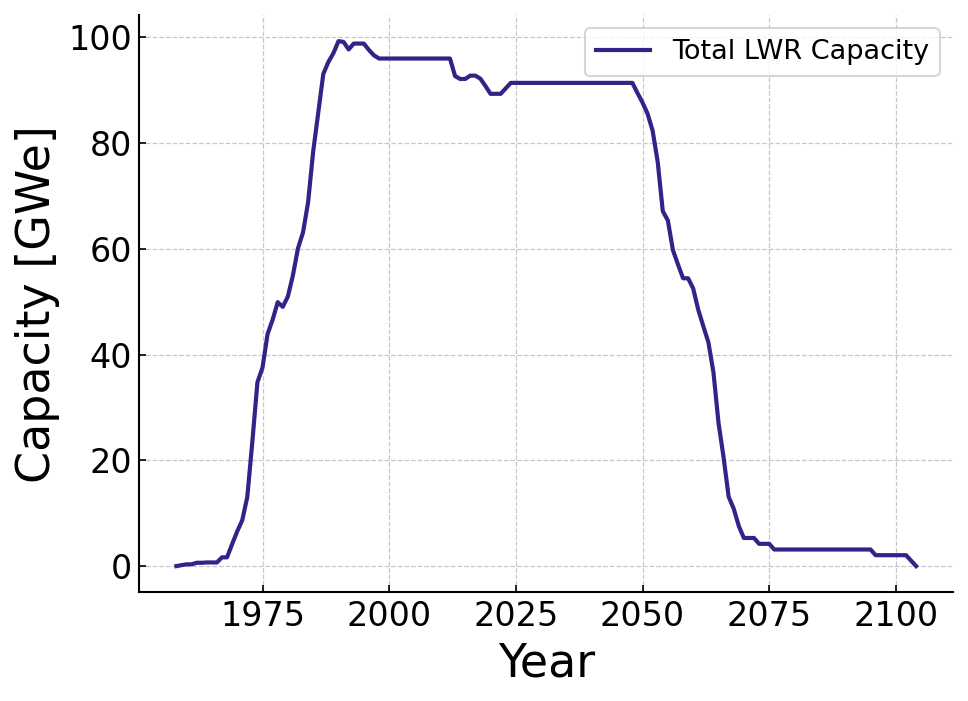

In [10]:
capacity_change_df[["Total LWR Capacity"]].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Total LWR Capacity')

## Capacity Expansion Calculations
In this section, I will perform the calculations required to do the energy demand increase. We will use the capacity from the transition_year variable in `scenario_definitions.py`

In [11]:
c

Total LWR capacity in 2029: 91345.6 MWe


In [11]:
def capacity_increase(df, base_col, rate, start_year=sd.transition_year, end_year=sd.sim_end_yr):
    """
    This function takes in an increase rate, and creates a new column in the
    dataframe populated with the increased capacity.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to add the new column to.
    base_col : str
        The name of the column to use as the base capacity.
        This column should contain the net capacity.
    rate : float
        The percentage of change in capacity year-to-year
        (e.g. 1.01 for a 1% increase).
    start_year : int
        The year to start the increase.
    end_year : int
        The year to end the increase.

    Returns
    -------
    df : pandas DataFrame
        The dataframe with the new column added.
    """
    for year in range(start_year, end_year):
        df.loc[year, f"{base_col} Inc {rate}"] = \
            df.loc[start_year, base_col] * (rate)**(year - start_year)

    for year in range(df.index[0], start_year):
        df.loc[year, f"{base_col} Inc {rate}"] = df.loc[year, base_col]

    df[f"New Capacity Inc {rate}"] = df[f"{base_col} Inc {rate}"] - df[base_col]
    return df

## No Growth Scenarios
Growth Rate: 1

In this section, we will use the functions in `reactor_deployment.py` to deploy the advanced reactors to meet demand.

In [12]:
no_growth_cap_df = capacity_change_df.copy()
capacity_increase(no_growth_cap_df, 'Total LWR Capacity', 1)

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1
1958,0.000,0.000000e+00,0.000,0.000
1959,182.225,1.822250e+02,182.225,0.000
1960,154.475,3.367000e+02,336.700,0.000
1961,0.000,3.367000e+02,336.700,0.000
1962,296.000,6.327000e+02,632.700,0.000
...,...,...,...,...
2100,0.000,2.066450e+03,91345.600,89279.150
2101,0.000,2.066450e+03,91345.600,89279.150
2102,0.000,2.066450e+03,91345.600,89279.150
2103,-1033.225,1.033225e+03,91345.600,90312.375


/tmp/ipykernel_13964/2167958972.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


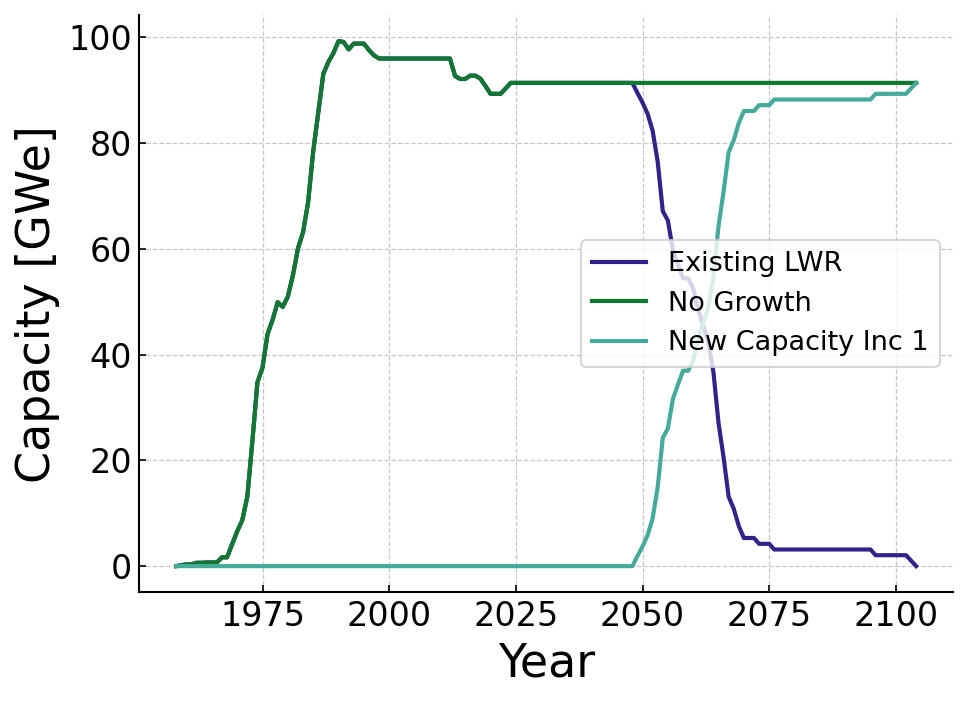

In [13]:
no_growth_cap_df[['Total LWR Capacity','Total LWR Capacity Inc 1','New Capacity Inc 1']].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')

### Greedy Deployment

In [14]:
# Copy the base capacity dataframe so we can modify it.
greedy_no_growth_cap_df = no_growth_cap_df.copy()

greedy_no_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1
1958,0.000,0.000000e+00,0.000,0.000
1959,182.225,1.822250e+02,182.225,0.000
1960,154.475,3.367000e+02,336.700,0.000
1961,0.000,3.367000e+02,336.700,0.000
1962,296.000,6.327000e+02,632.700,0.000
...,...,...,...,...
2100,0.000,2.066450e+03,91345.600,89279.150
2101,0.000,2.066450e+03,91345.600,89279.150
2102,0.000,2.066450e+03,91345.600,89279.150
2103,-1033.225,1.033225e+03,91345.600,90312.375


In [15]:
# Make a column for the year.
greedy_no_growth_cap_df = greedy_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [16]:
# Use the greedy deployment function to deploy reactors.
dep.greedy_deployment(greedy_no_growth_cap_df, "New Capacity Inc 1", sd.ad_reactors, sd.transition_year)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1,num_AP1000,num_Xe100,num_MMR,AP1000Decom,Xe100Decom,MMRDecom,total_cap,new_cap,new_AP1000_cap,AP1000_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap
0,1958,0.000,0.000000e+00,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1959,182.225,1.822250e+02,182.225,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1960,154.475,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1961,0.000,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1962,296.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2100,0.000,2.066450e+03,91345.600,89279.150,79,12,25,0,0,10,89328,89278,88243,88243,960,960,75,125
143,2101,0.000,2.066450e+03,91345.600,89279.150,79,12,29,0,0,14,89348,89278,88243,88243,960,960,75,145
144,2102,0.000,2.066450e+03,91345.600,89279.150,79,12,30,0,0,15,89353,89278,88243,88243,960,960,75,150
145,2103,-1033.225,1.033225e+03,91345.600,90312.375,80,11,30,0,0,16,90390,90310,89360,89360,880,880,70,150


In [18]:
# Write the results to a csv
greedy_no_growth_cap_df.to_csv('no_growth/greedy_no_growth_cap.csv', index=False)

/home/nsryan/anaconda3/envs/cyclus/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Capacity [GWe]')

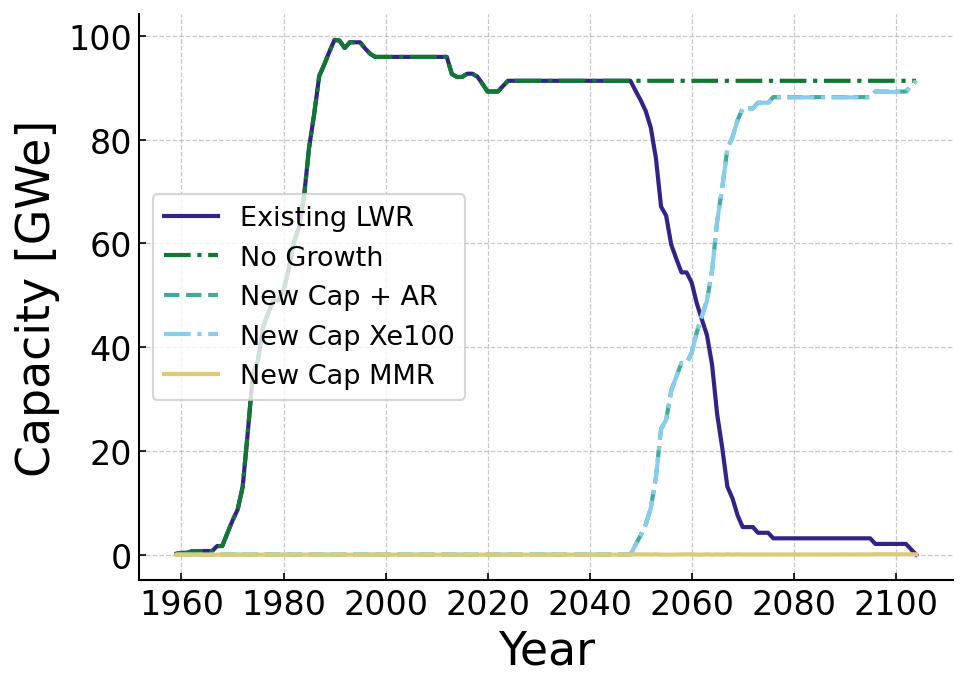

In [19]:
e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

greedy_no_growth_cap_df[g].plot(x='Year', logy=False, style=gs)


plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

In [20]:
dep.analyze_algorithm(greedy_no_growth_cap_df, "Total LWR Capacity Inc 1", "new_cap", sd.ad_reactors)

{'above_count': 0,
 'below_count': 146,
 'equal_count': 0,
 'above_percentage': 0.0,
 'below_percentage': 100.0,
 'total_above': 0.0,
 'total_below': -7772443.999999999,
 'percent_provided': {'Xe100': 99.89685129012294, 'MMR': 0.10314870987706559}}

### Pre Determined Distribution
This section I will skip at the moment as I have not put enough thought into scenarios that would be of interested based on what companies are saying. At present, I think staggering the initial deployment of each technology is the most i can say about the distribution of any specific reactor technology based on the deadlines they are trying to meet.

### Rough Random Deployment
I will only use the rough case as I am not confident the true random case will converge. 

Tolerance will be 5, and the seed will be set for now with the `True` argument.

In [21]:
# Make a copy of the no growth capacity dataframe so we can modify it.
rrd_no_growth_cap_df = no_growth_cap_df.copy()

rrd_no_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1
1959,182.225,1.822250e+02,182.225,0.000
1960,154.475,3.367000e+02,336.700,0.000
1961,0.000,3.367000e+02,336.700,0.000
1962,296.000,6.327000e+02,632.700,0.000
1963,0.000,6.327000e+02,632.700,0.000
...,...,...,...,...
2100,0.000,2.066450e+03,91345.600,89279.150
2101,0.000,2.066450e+03,91345.600,89279.150
2102,0.000,2.066450e+03,91345.600,89279.150
2103,-1033.225,1.033225e+03,91345.600,90312.375


In [22]:
# Make a column for the year.
rrd_no_growth_cap_df = rrd_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [23]:
# Use the random reactor deployment function to deploy reactors.
dep.rand_deployment(rrd_no_growth_cap_df, "New Capacity Inc 1", sd.ad_reactors, sd.transition_year, set_seed=True, rough=True, tolerance=5)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap
0,1959,182.225,1.822250e+02,182.225,0.000,0,0,0,0,0,0,0,0,0,0
1,1960,154.475,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0
2,1961,0.000,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0
3,1962,296.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0
4,1963,0.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,91345.600,89279.150,1047,2667,0,1570,97095,89245,83760,83760,5485,13335
142,2101,0.000,2.066450e+03,91345.600,89279.150,1047,2715,0,1618,97335,89245,83760,83760,5485,13575
143,2102,0.000,2.066450e+03,91345.600,89279.150,1047,2746,0,1649,97490,89245,83760,83760,5485,13730
144,2103,-1033.225,1.033225e+03,91345.600,90312.375,1058,2814,0,1690,98710,90260,84640,84640,5620,14070


In [24]:
# Make a csv of the results.
rrd_no_growth_cap_df.to_csv('no_growth/rrd_no_growth_cap.csv', index=False)

Text(0, 0.5, 'Capacity [GWe]')

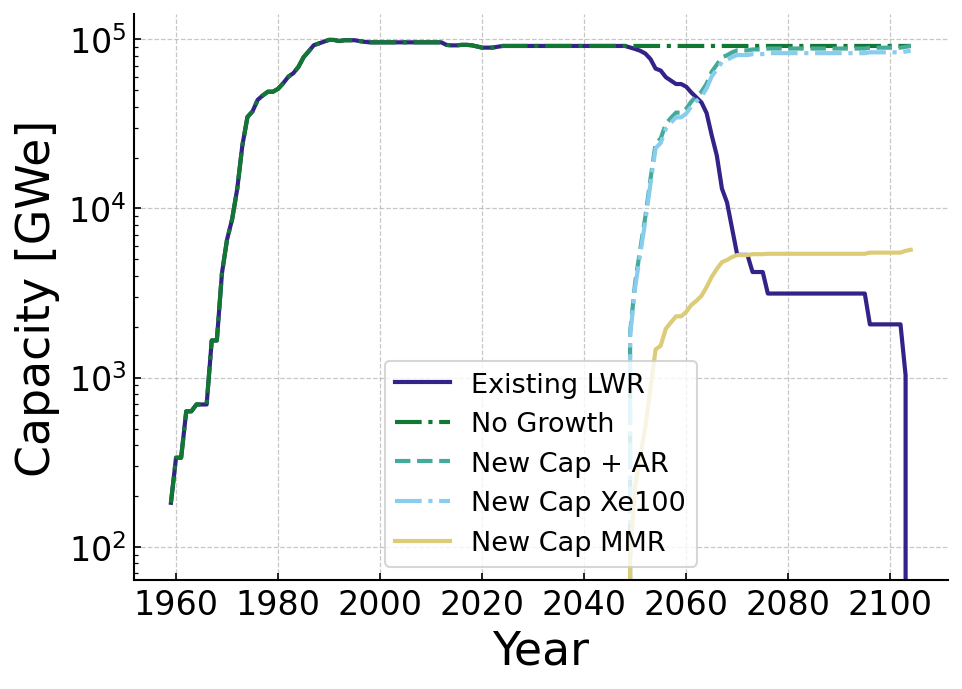

In [25]:
g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

rrd_no_growth_cap_df[g].plot(x='Year', logy=True, style=gs)

plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

In [26]:
dep.analyze_algorithm(rrd_no_growth_cap_df, "Total LWR Capacity Inc 1", "new_cap", sd.ad_reactors)

{'above_count': 0,
 'below_count': 146,
 'equal_count': 0,
 'above_percentage': 0.0,
 'below_percentage': 100.0,
 'total_above': 0.0,
 'total_below': -7773588.999999999,
 'percent_provided': {'Xe100': 90.166559740635, 'MMR': 9.833440259365013}}

## Rough Random + Greedy

In [27]:
# Make a copy of the no growth capacity dataframe so we can modify it.
rr_pgd_no_growth_cap_df = no_growth_cap_df.copy()

In [28]:
# Make a column for the year.
rr_pgd_no_growth_cap_df = rr_pgd_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [29]:
# Use the random reactor deployment function to deploy reactors.
dep.rand_greedy_deployment(rr_pgd_no_growth_cap_df, "New Capacity Inc 1", sd.ad_reactors, sd.transition_year, set_seed=True)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap,remaining_cap,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR
0,1959,182.225,1.822250e+02,182.225,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
1,1960,154.475,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
2,1961,0.000,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
3,1962,296.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
4,1963,0.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,91345.600,89279.150,1047,4737,0,2064,204540,107445,83760,83760,13365,23685,34.150,0,1047,2070,2667
142,2101,0.000,2.066450e+03,91345.600,89279.150,1047,4884,0,2163,205515,108180,83760,83760,13605,24420,34.150,0,1047,2169,2715
143,2102,0.000,2.066450e+03,91345.600,89279.150,1047,4977,0,2225,206135,108645,83760,83760,13760,24885,34.150,0,1047,2231,2746
144,2103,-1033.225,1.033225e+03,91345.600,90312.375,1058,5137,0,2313,209035,110325,84640,84640,14120,25685,52.375,0,1058,2323,2814


In [30]:
# Make a csv of the results.
rr_pgd_no_growth_cap_df.to_csv('no_growth/rr_pgd_no_growth_cap.csv', index=False)

Text(0, 0.5, 'Capacity [GWe]')

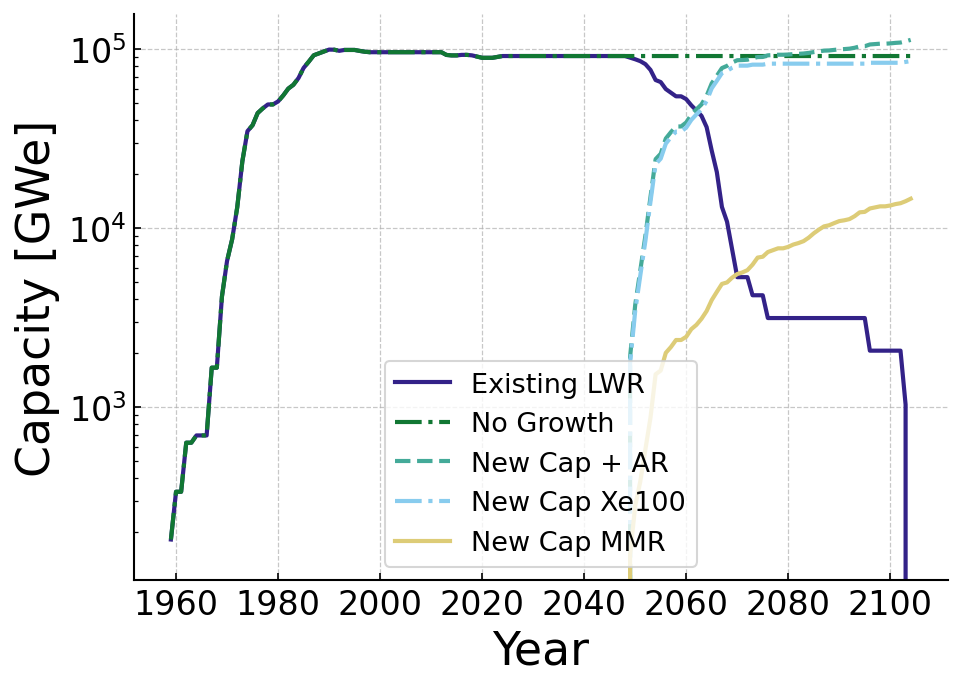

In [31]:
g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

rr_pgd_no_growth_cap_df[g].plot(x='Year', logy=True, style=gs)

plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

In [32]:
dep.analyze_algorithm(rr_pgd_no_growth_cap_df, "Total LWR Capacity Inc 1", "new_cap", sd.ad_reactors)

{'above_count': 29,
 'below_count': 117,
 'equal_count': 0,
 'above_percentage': 19.863013698630137,
 'below_percentage': 80.13698630136986,
 'total_above': 261552.59999999983,
 'total_below': -7683536.599999997,
 'percent_provided': {'Xe100': 44.05170294434498, 'MMR': 7.092376333981543}}